# Semantic interpretation.

Semantic interpretation is a NLP technique to draw the meaning of a text/sentence. In this implementation, we will focuse on determining two sentences in different languages (english and spanish) have the same meaning.

Some possible sentences for our dataset are:

- Woman buys new car & Mujer compra coche nuevo (1)
- Man buys blue car & Mujer compra coche azul (0)
- Woman buys new car & Mujer compra automóvil nuevo (1)
- Man buys new car & Hombre compra automóvil viejo (0)
- Woman buys old car & Mujer adquiere coche viejo (1)
- Woman buys new car & Mujer hurta coche nuevo (0)
- Woman buys new car & Mujer roba coche rojo (0)
- Woman steals red car & Mujer roba coche rojo (0)
...

Where each example follows this structure: Sentence in english & Sentence in spanish (meaning coincidence label).

Our dataset is built using this vocabulary:


| Subject | Verbs | Objects | Adjectives | | Nombres | Verbos | Objetos | Adjetivos |
| --- | --- | --- | --- | | --- | --- | --- | --- |
| Woman | steals | car | old | | Mujer | roba | coche | viejo |
| Man | buys | sofa | red | | Hombre | hurta | automóvil | nuevo |
|  | purchases | coach | blue | |  | compra | sillón | |
|  | breaks | notebook | new | |  | rompe | cuaderno | |


The proposed vocabulary has 12 words and two different kind of sentences for each language:
- Subject + Verb + Object (32 sentences)
- Subject + Verb + (Adj +) Object (64 sentences)

This makes 96 sentences per language and hence 9216 possible combinations.

## 1. Create dataset


### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have three types of words: nouns, adjectives, verbs (transitive). We also distinguish two different types of nouns: objects and subjects. 

In [1]:
import numpy as np
import pickle

In [41]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns (subjects)
man, woman = Word('man', n), Word('woman', n)
mujer, hombre = Word('mujer', n), Word('hombre', n)
# nouns (objects)
car, sofa, coach, notebook = Word('car', n), Word('sofa', n), Word('coach', n), Word('notebook', n)
coche, automovil, sillon, cuaderno = Word('coche', n), Word('automovil', n), Word('sillón', n), Word('cuaderno', n)
# adjectives
old, new = Word('old', n @ n.l), Word('new', n @ n.l)
viejo, nuevo = Word('viejo', n.r @ n), Word('nuevo', n.r @ n )
# Transitive verbs
buys, purchases, steals, breaks  = Word('buys', n.r @ s @ n.l), Word('purchases', n.r @ s @ n.l), Word('steals', n.r @ s @ n.l), Word('breaks', n.r @ s @ n.l)
compra, roba, hurta, rompe  = Word('compra', n.r @ s @ n.l), Word('roba', n.r @ s @ n.l), Word('hurta', n.r @ s @ n.l), Word('rompe', n.r @ s @ n.l)

subjects = [man, woman]
sujetos = [mujer, hombre]
verbs = [buys, purchases, steals, breaks]
verbos = [compra, roba, hurta, rompe]
adjectives = [old, new]
adjetivos = [viejo, nuevo]
objects = [car, sofa, coach, notebook]
objetos = [coche,  sillon, automovil, cuaderno]


vocab_E = subjects + verbs + adjectives + objects 
vocab_S = sujetos + verbos + adjetivos + objetos

### 1.2. Define the grammar

In this dataset we are going to consider the following structures to construct the sentences:

- noun + t. verb + noun



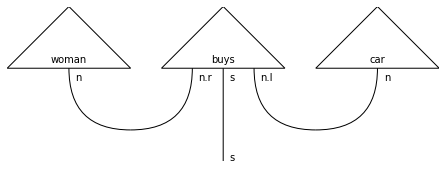

In [15]:
from discopy import Cup, Id, pregroup

grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ buys @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + adjective + noun (for english)

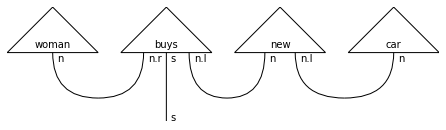

In [16]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n)
sentence = woman @ buys @ new @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + noun +adjective (for spanish)

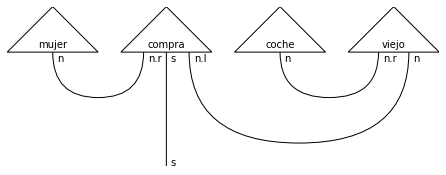

In [53]:
grammar =  Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)
sentence = mujer @ compra @ coche @ viejo >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [72]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'NVN' :  Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'NVAN' : Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n),
    'NVNA' : Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)}                                                                   

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# English noun+verb+noun sentences
parsing_NVNe = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in subjects for verb in verbs for obj in objects}
sentences_NVNe = list(parsing_NVNe.keys())
for sentence in sentences_NVNe:
    diagram = parsing_NVNe[sentence]
    data_psr[sentence] = parsing_NVNe[sentence]
    
# Spanish noun+verb+noun sentences
parsing_NVNs = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in sujetos for verb in verbos for obj in objetos}
sentences_NVNs = list(parsing_NVNs.keys())
for sentence in sentences_NVNs:
    diagram = parsing_NVNs[sentence]
    data_psr[sentence] = parsing_NVNs[sentence]
    
# English noun+verb+adjective+noun sentences
parsing_NVANe = {"{} {} {} {}.".format(subj, verb, adj, obj): subj @ verb @ adj @ obj  >> grammar_dict['NVAN']
            for subj in subjects  for verb in verbs for adj in adjectives for obj in objects}
sentences_NVANe = list(parsing_NVANe.keys())
for sentence in sentences_NVANe:
    diagram = parsing_NVANe[sentence]
    data_psr[sentence] = parsing_NVANe[sentence]
    
# Spanish noun+verb+noun+adjectives sentences
parsing_NVNAs = {"{} {} {} {}.".format(subj, verb, obj, adj): subj @ verb @ obj @ adj  >> grammar_dict['NVNA']
            for subj in sujetos for verb in verbos for obj in objetos  for adj in adjetivos}
sentences_NVNAs = list(parsing_NVNAs.keys())
for sentence in sentences_NVNAs:
    diagram = parsing_NVNAs[sentence]
    data_psr[sentence] = parsing_NVNAs[sentence]

----->>>>> Hasta aquí he modificado el código, esta parte de arriba crea las frase. Ahora quedaría la parte nueva de emparejar la frases en un txt y asignarles la label.

Now, we have the dataset with the sentences and their corresponding meaning and grammar. The next step is to design the corresponding quantum circuits to determine the sentiment for each sentence. We are aiming to distinguish between four different emotions: happy (0), sad (1), angry (2), scared (3). However, some sentences of the dataset cannot be clearly classified according to this criteria (for example, 'Man is old'). Therefore, the next step is to manually modify the dataset so all the sentences can be classified according to this criteria. In order to do that we will create a .txt file and assign the corresponding class to the viable sentences.

In [7]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'ADJ_N' : Id(n) @ Cup(n.l, n),
    'ADJ_N_IV' : Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n)}
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)
data_file = open('.data.txt', 'w')

# Attributive sentences
parsing_att = {"{} {}.".format(adj, noun): adj @ noun >> grammar_dict['ADJ_N']
            for adj in adjectives for noun in nouns}
sentences_att = list(parsing_att.keys())
for sentence in sentences_att:
    with open('./data.txt', 'a') as f:
        f.write(sentence + '_att \n')
    
# Intransitive sentences
parsing_int = {"{} {} {}.".format(adj, noun, int_verb): adj @ noun @ int_verb >> grammar_dict['ADJ_N_IV']
            for adj in adjectives for noun in nouns for int_verb in int_verbs}
sentences_int = list(parsing_int.keys())
for sentence in sentences_int:
    with open('./data.txt', 'a') as f:
        f.write(sentence + '_int \n')

# Transitive sentences
parsing_tra = {"{} {} {}.".format(subj, t_verb, obj):  subj @ t_verb @ obj >> grammar_dict['N_TV_N']
            for subj in nouns for t_verb in t_verbs for obj in nouns}
sentences_t = list(parsing_t.keys())
for sentence in sentences_t:
    with open('./data.txt', 'a') as f:
        f.write(sentence + '_tra \n')
        
data_file.close()

### 1.3. Processed the data

In [8]:
with open('processed_data.txt') as f:
    data = f.readlines()

In [9]:
labels_dict = {}
data_psr_dict = {}
sent_type = {}
for sentence in data:
    sentstr = sentence[:-7]
    if sentence[-6:-3] == 'att':
        diagram = parsing_att[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'att'
    elif sentence[-6:-3] == 'int':
        diagram = parsing_int[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'int'
    elif sentence[-6:-3] == 'tra':
        diagram = parsing_tra[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'tra'

In [10]:
c0 = 0
c1 = 0
c2 = 0
c3 = 0
for value in labels_dict.values():
    if value == '0':
        c0 +=1
    elif value == '1':
        c1 += 1
    elif value == '2':
        c2 += 1
    elif value == '3':
        c3 += 1
print('Number of elements for each sentiment')
print('Happy: ', c0)
print('Sad: ', c1)
print('Angry: ', c2)
print('Scared: ', c3)
print('Total', len(data_psr_dict))

Number of elements for each sentiment
Happy:  14
Sad:  24
Angry:  21
Scared:  27
Total 86


Now we have our dataset! The only problem left is the fact that the cups used in the diagrams are too resource consumming. Luckily, it is possible to remove them by transforming the states into effects (we are just doing this with the nouns as in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources). Let us see some examples

- Attributive sentence

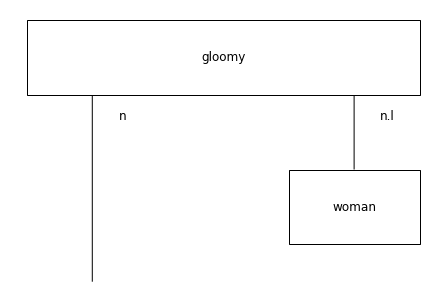

In [11]:
from discopy import Cap, Box
woman2 = Box('woman', n.l, Ty())
words_new = (Cap(n, n.l)) >> (gloomy) @ Id(n) @ woman2
sentence = words_new >> grammar_dict['ADJ_N']
sentence = sentence.normal_form()
sentence.draw()

- Intransitive sentence

In [12]:
woman2 = Box('woman', n.l, Ty())
words_new = (Cap(n, n.l)) >> (old @ Id(n) @ woman2 @ laughs)
sentence = words_new >> grammar_dict['ADJ_N_IV']
sentence = sentence.normal_form()

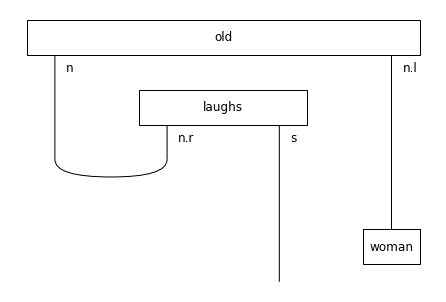

In [13]:
sentence.draw()

- Transitive sentence

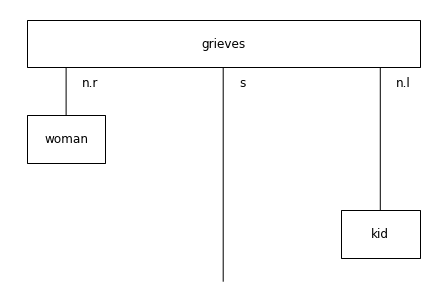

In [14]:
woman2 = Box('woman', n.r, Ty())
kid2 = Box('kid', n.l, Ty())
words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (woman2 @ Id(n) @ grieves @ Id(n) @ kid2)
sentence = words_new >> grammar_dict['N_TV_N']
sentence = sentence.normal_form()
sentence.draw()

Let us apply this to our entire dataset.

In [15]:
data_new_psr_dict = {}
for sentstr in data_psr_dict.keys():
    num_words = len(sentstr.split(' '))
    words = data_psr_dict[sentstr].boxes[:num_words]
    if sent_type[sentstr] == 'att':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0]) @ Id(n) @ noun
        sentence = words_new >> grammar_dict['ADJ_N']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif sent_type[sentstr] == 'int':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2])
        sentence = words_new >> grammar_dict['ADJ_N_IV']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif sent_type[sentstr] == 'tra':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[2].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
        sentence = words_new >> grammar_dict['N_TV_N']
        data_new_psr_dict[sentstr] = sentence.normal_form()

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [16]:
vocab_psr = []
for word in vocab:
    if word.cod == Ty('n'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)